# Using various classifiers on the red wine dataset

On this notebook we attempt to test different classifiers on the popular [red wine dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?datasetId=4458&sortBy=voteCount).

## Columns description

1. **fixed acidity**: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. **volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. **citric acid**: found in small quantities, citric acid can add 'freshness' and flavor to wines
4. **residual sugar**: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter
5. **chlorides**: the amount of salt in the wine
6. **free sulfur dioxide**: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents
7. **total sulfur dioxide**: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2
8. **density**: the density of water is close to that of water depending on the percent alcohol and sugar content
9. **ph**: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4
10. **sulphates**: a wine additive which can contribute to sulfur dioxide gas (S02) levels, which acts as an antimicrobial
11. **alcohol sulfur dioxide**: the percent alcohol content of the wine
12. **quality**: output variable (based on sensory data, score between 3 and 8) 

### Imports and directories to save results

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)

save = True
sns.set_palette("muted")

if save:
    os.makedirs("figures/", exist_ok = True)
    os.makedirs("tables/", exist_ok = True)

### The dataset

In [3]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
rows, columns = df.shape
print(f"There are {rows} rows and {columns} columns")

There are 1599 rows and 12 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


There are no missing values or categorical features. Every feature is float and *quality* is int

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the discrepancy between *min* and *max* values we can see that these dataset has a lot of outliers

### Data analysis

In [13]:
quality_counts = df.groupby("quality").quality.sum()
quality_counts

quality
3      30
4     212
5    3405
6    3828
7    1393
8     144
Name: quality, dtype: int64

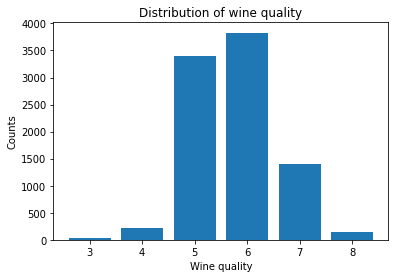

In [16]:
plt.bar(x = quality_counts.index, height=quality_counts.values)
plt.xlabel("Wine quality")
plt.ylabel("Counts")
plt.title("Distribution of wine quality")
plt.show()

From this bar plot we can see that this dataset is unbalanced with quality 5 and 6 having a lot more examples than the others.<br>
This is a problem that we will deal with later on

Now, for each feature, we are going to present:
1. histogram with the density function plotted against the normal density function
2. bar plot of how each feature influences the quality of the wine
3. finally, a box-plot to verify that there are a lot of outliers

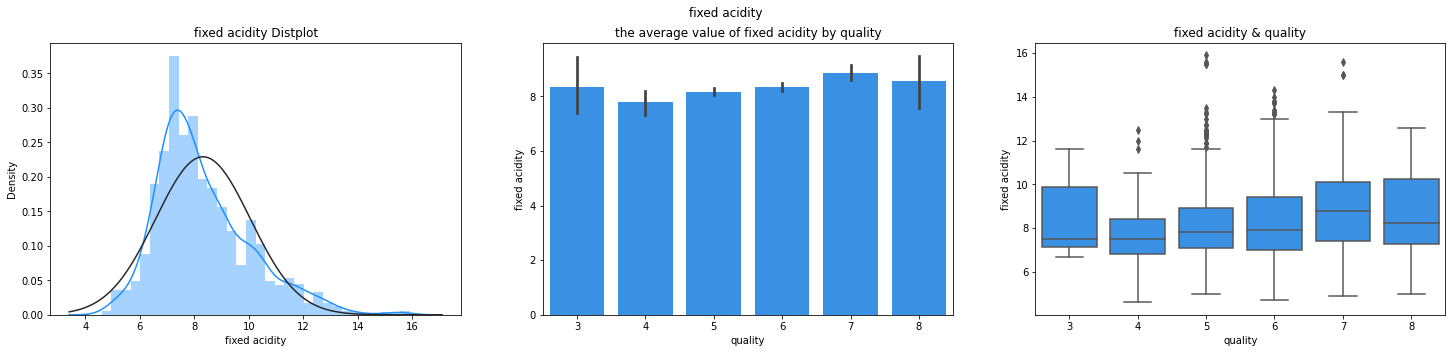

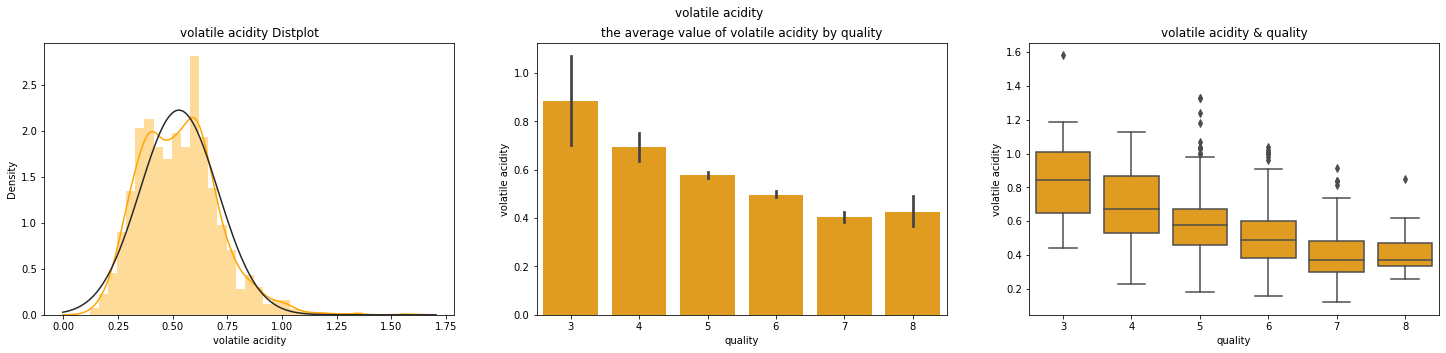

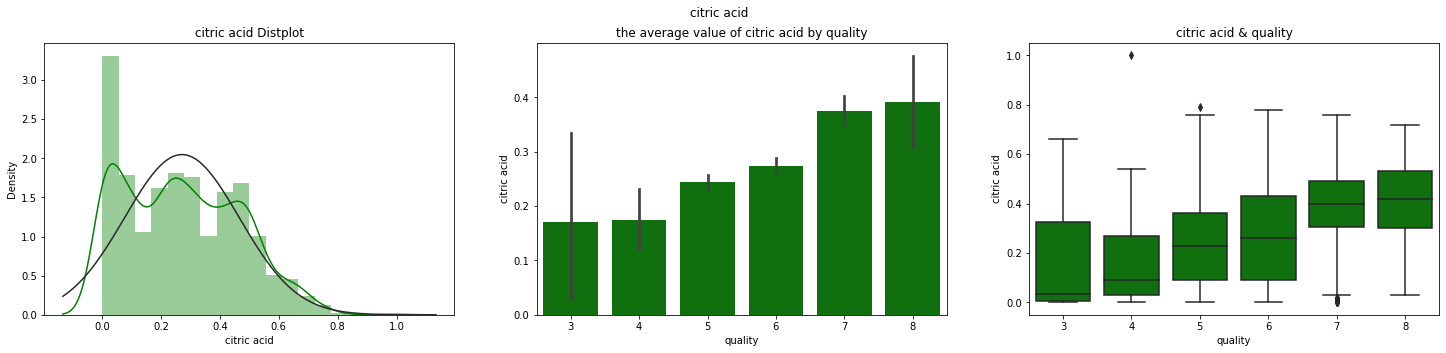

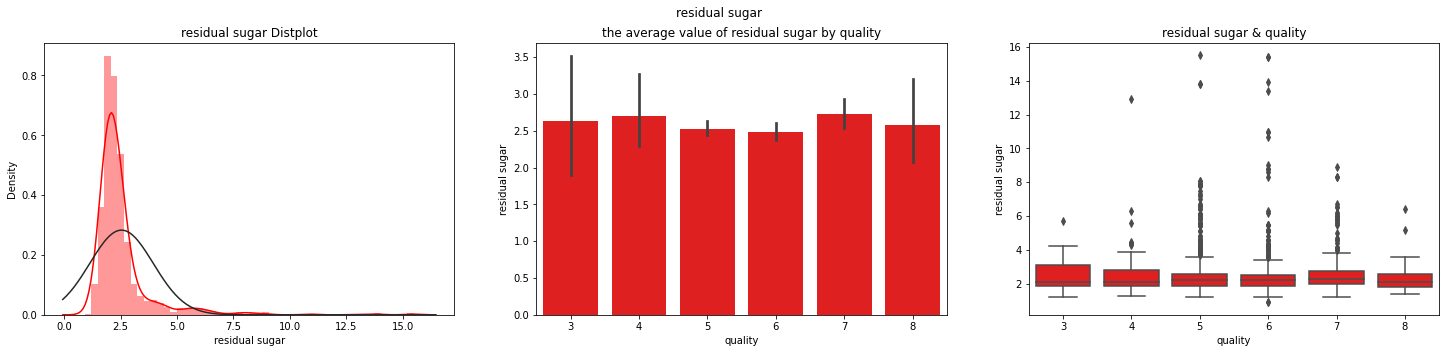

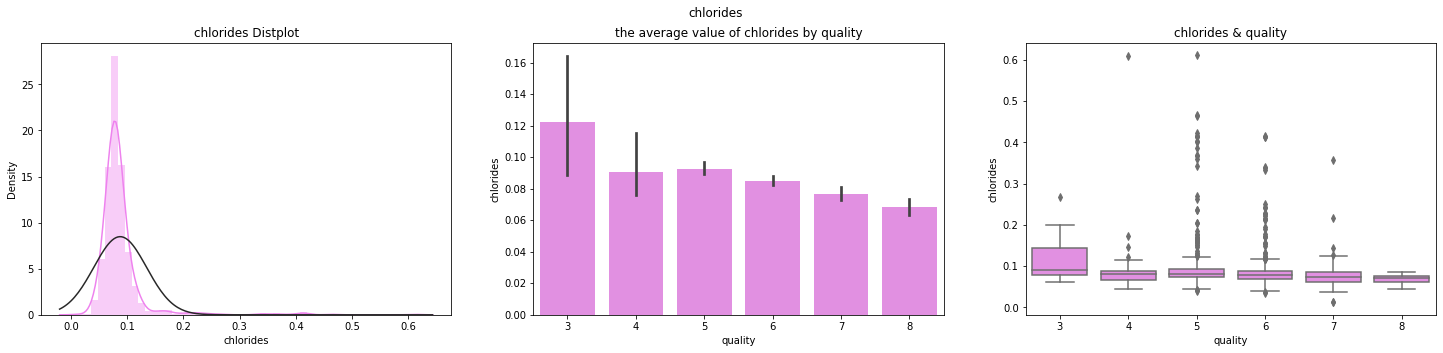

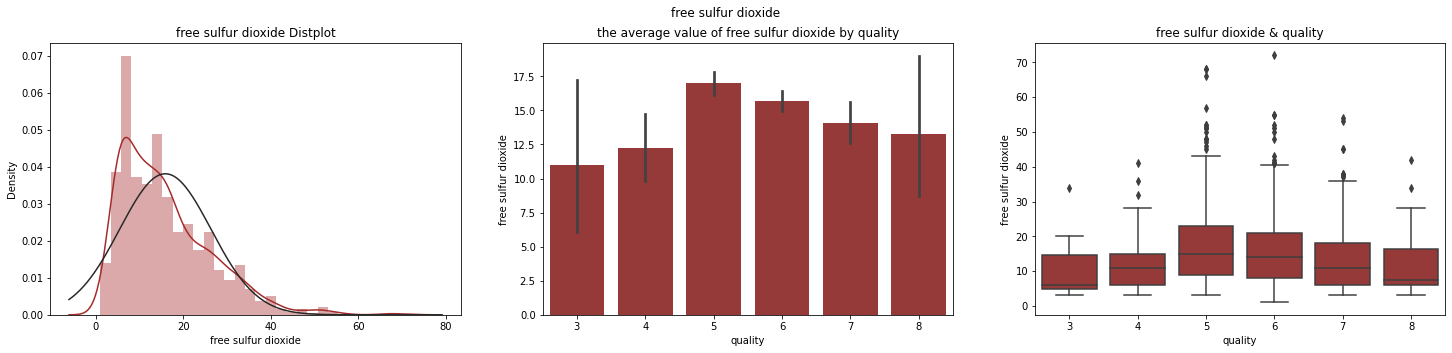

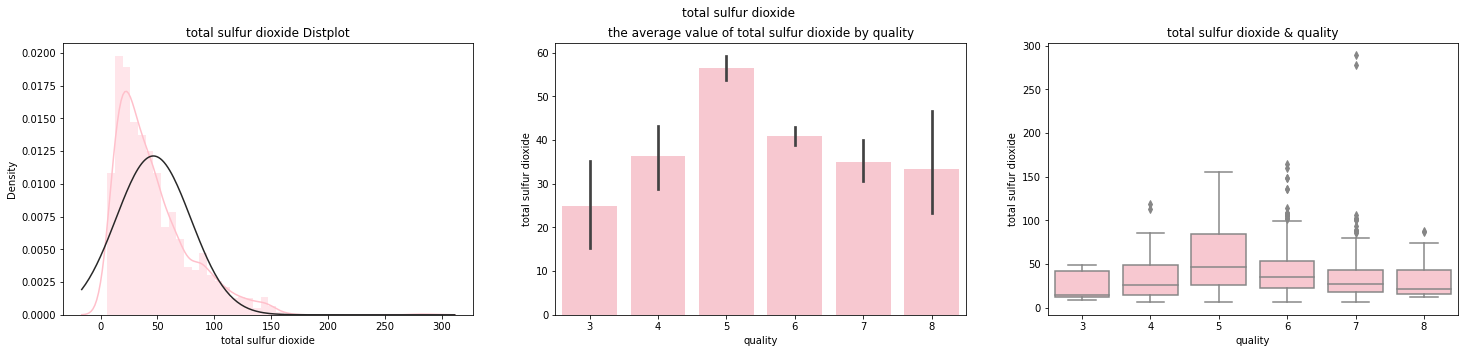

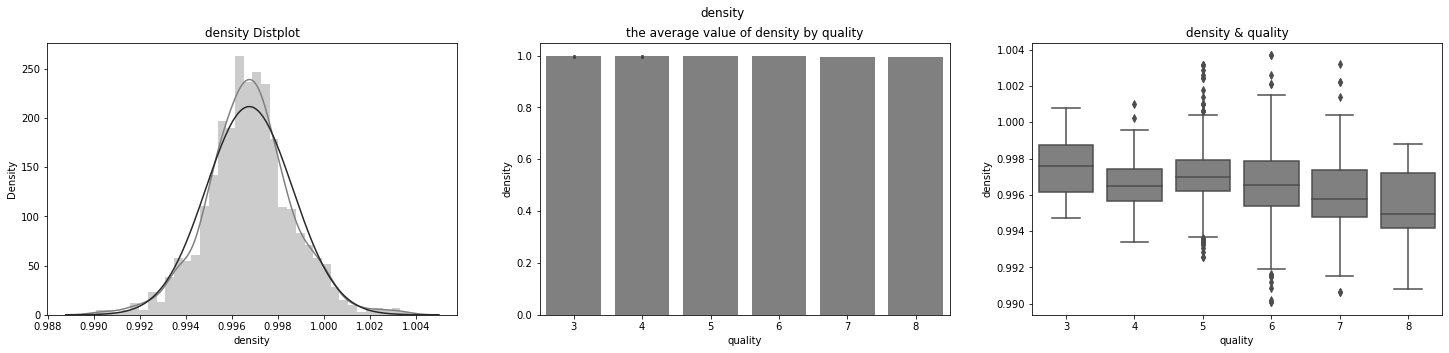

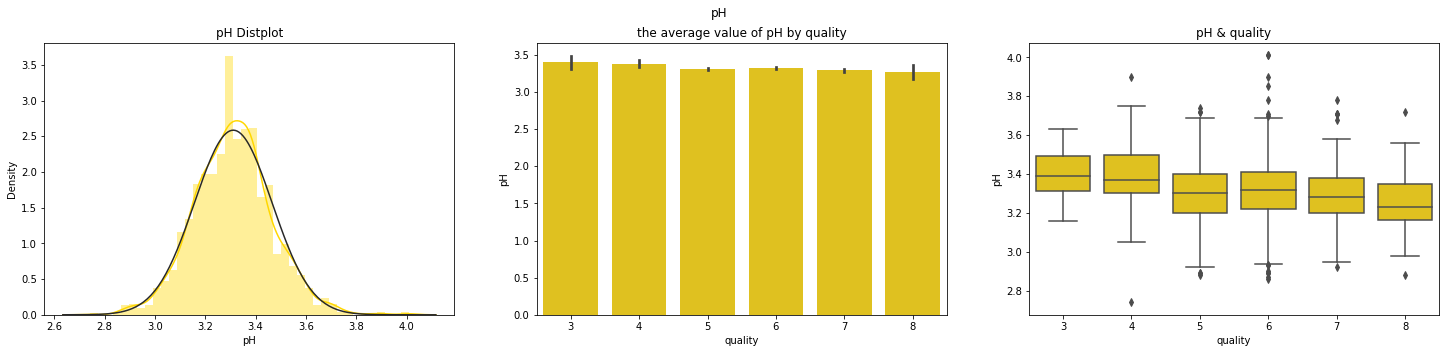

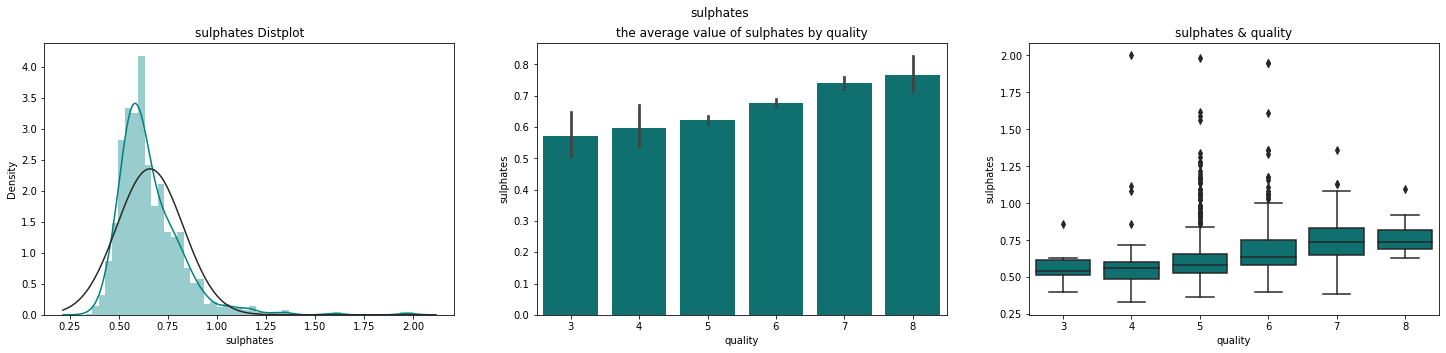

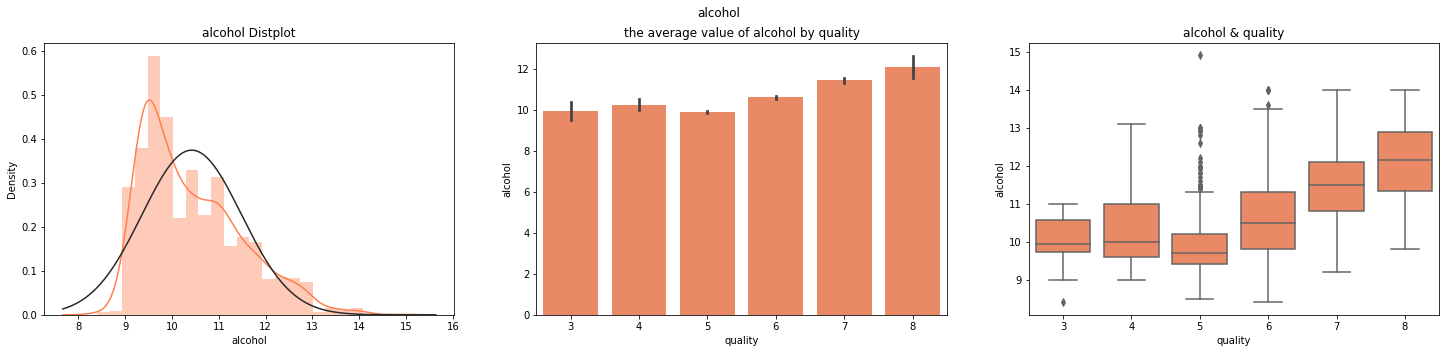

In [64]:
colors = ["dodgerblue", "orange", "green", "red", "violet", "brown", "pink", "grey", "gold", "teal", "coral"]

for column, color in zip(df.columns[:-1], colors):
    plt.figure(figsize=[25, 5])

    plt.subplot(1, 3, 1)
    sns.distplot(df[column], fit=norm, color=color)
    plt.title(f"{column} Distplot")
    plt.subplot(1, 3, 2)
    sns.barplot(x = df["quality"], y = df[column], color=color)
    plt.title(f"the average value of {column} by quality")
    plt.subplot(1, 3, 3)
    sns.boxplot(df['quality'], df[column], color=color)
    plt.title(f"{column} & quality")
    plt.suptitle(column)
    
plt.show()

Some conclusions:

1. **fixed acidity**: Given on how close the average values of fixed acidity by quality are we can say that fixed acidity does not have much effect on the quality
2. **volatile acidity**: from the average values of volatile acidity by quality, we can say that the decrease in volatile acidity seems to affect the quality positively
3. **citric acid**: the increase in citric acid seems to affect the quality positively
4. **residual sugar**: Given on how close the average values of residual sugary by quality are we can say that residual sugar does not have much effect on the quality
5. **chlorides**: the decrease in chlorides seems to affect the quality positively
6. **free sulfur dioxide**: Examining the average values of free sulfur dioxide by quality we cant really see that they have the free sulfur dioxide has a regular effect on the quality
7. **total sulfur dioxide**: Examining the average values of total sulfur dioxide by quality we cant really see that they have the total sulfur dioxide has a regular effect on the quality
8. **density**: Given on how close the average values of density by quality are we can say that density does not have much effect on the quality. Very close to a normal distribution
9. **ph**: We can see that the slight decrease on ph levels has a positive effect on quality. Also, very close to a normal distribution
10. **sulphates**: The higher the value of sulphates the more positive the quality is
11. **alcohol sulfur dioxide**: The increase on alcohol sulfur dioxide has a positive effect on quality

Overall, almost every column has a lot of outliers expect **citric acid**